In [1]:
!git clone https://github.com/venkyyuvy/image_classifier.git

Cloning into 'image_classifier'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 30 (delta 11), reused 28 (delta 9), pack-reused 0
Unpacking objects: 100% (30/30), 358.58 KiB | 1.72 MiB/s, done.


In [2]:
cd image_classifier/S6

/content/image_classifier/S6


In [3]:

import torch
from torch import optim, nn

from model import Net, model_train, model_test,\
     summary_printer, plot_loss_n_acc
from utils import prepare_mnist_data,\
     plot_img_batch

from torchvision import transforms
from torch.nn import functional as F

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Data preparation

In [5]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

In [6]:
train_loader, test_loader = prepare_mnist_data(
    train_transforms, test_transforms, batch_size=16)

100%|██████████| 9912422/9912422 [00:00<00:00, 139258321.84it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 20015811.93it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36500862.38it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3330512.02it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



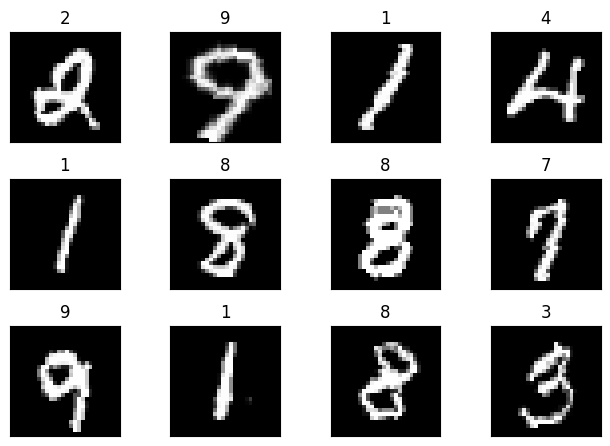

In [7]:
_ = plot_img_batch(train_loader)

## Modelling

In [11]:

class Net(nn.Module):
    def __init__(self, drop_p=0.15):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(drop_p)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(drop_p)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 128, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(drop_p)
        )
        self.avg = nn.AvgPool2d(2)
        self.fc = nn.Sequential(
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary_printer(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
            Conv2d-4           [-1, 16, 28, 28]           4,624
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 16, 16]             272
             ReLU-10           [-1, 16, 16, 16]               0
      BatchNorm2d-11           [-1, 16, 16, 16]              32
           Conv2d-12           [-1, 32, 16, 16]           4,640
             ReLU-13           [-1, 32, 16, 16]               0
      BatchNorm2d-14           [-1, 32,

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    model_train(model, device, train_loader, optimizer)
    model_test(model, device, test_loader)
    scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1


Train: Loss=0.1411             Batch_id=3749 Accuracy=86.59: 100%|██████████| 3750/3750 [02:41<00:00, 23.25it/s]


Test set: Average loss: 0.0917,        Accuracy: 58337/60000 (97.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2


Train: Loss=0.0567             Batch_id=3749 Accuracy=94.34: 100%|██████████| 3750/3750 [02:40<00:00, 23.44it/s]


Test set: Average loss: 0.0665,        Accuracy: 58749/60000 (97.92%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3


Train: Loss=0.2017             Batch_id=3749 Accuracy=95.46: 100%|██████████| 3750/3750 [02:43<00:00, 22.89it/s]


Test set: Average loss: 0.0493,        Accuracy: 59088/60000 (98.48%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 4


Train: Loss=0.1088             Batch_id=3749 Accuracy=96.06: 100%|██████████| 3750/3750 [02:42<00:00, 23.09it/s]


Test set: Average loss: 0.0424,        Accuracy: 59196/60000 (98.66%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 5


Train: Loss=0.0921             Batch_id=3749 Accuracy=96.36: 100%|██████████| 3750/3750 [02:40<00:00, 23.34it/s]


Test set: Average loss: 0.0376,        Accuracy: 59294/60000 (98.82%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6


Train: Loss=0.1005             Batch_id=3749 Accuracy=96.62: 100%|██████████| 3750/3750 [02:44<00:00, 22.84it/s]


Test set: Average loss: 0.0334,        Accuracy: 59371/60000 (98.95%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.3854             Batch_id=3749 Accuracy=96.79: 100%|██████████| 3750/3750 [02:44<00:00, 22.79it/s]


Test set: Average loss: 0.0336,        Accuracy: 59347/60000 (98.91%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.2431             Batch_id=3749 Accuracy=96.99: 100%|██████████| 3750/3750 [02:41<00:00, 23.17it/s]


Test set: Average loss: 0.0305,        Accuracy: 59413/60000 (99.02%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.0091             Batch_id=3749 Accuracy=97.04: 100%|██████████| 3750/3750 [02:41<00:00, 23.28it/s]


Test set: Average loss: 0.0304,        Accuracy: 59430/60000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.0104             Batch_id=3749 Accuracy=97.16: 100%|██████████| 3750/3750 [02:40<00:00, 23.39it/s]


Test set: Average loss: 0.0300,        Accuracy: 59451/60000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.0106             Batch_id=3749 Accuracy=97.39: 100%|██████████| 3750/3750 [02:34<00:00, 24.21it/s]


Test set: Average loss: 0.0290,        Accuracy: 59439/60000 (99.06%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.2258             Batch_id=3749 Accuracy=97.48: 100%|██████████| 3750/3750 [02:34<00:00, 24.33it/s]


Test set: Average loss: 0.0276,        Accuracy: 59482/60000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 13


Train: Loss=0.0051             Batch_id=3749 Accuracy=97.53: 100%|██████████| 3750/3750 [02:35<00:00, 24.05it/s]


Test set: Average loss: 0.0315,        Accuracy: 59388/60000 (98.98%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 14


Train: Loss=0.0067             Batch_id=3749 Accuracy=97.55: 100%|██████████| 3750/3750 [02:40<00:00, 23.36it/s]


Test set: Average loss: 0.0317,        Accuracy: 59408/60000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 15


Train: Loss=0.0082             Batch_id=3749 Accuracy=97.56: 100%|██████████| 3750/3750 [02:40<00:00, 23.36it/s]


Test set: Average loss: 0.0233,        Accuracy: 59544/60000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 16


Train: Loss=0.0008             Batch_id=3749 Accuracy=98.03: 100%|██████████| 3750/3750 [02:38<00:00, 23.62it/s]


Test set: Average loss: 0.0197,        Accuracy: 59616/60000 (99.36%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 17


Train: Loss=0.0251             Batch_id=3749 Accuracy=98.15: 100%|██████████| 3750/3750 [02:38<00:00, 23.64it/s]


Test set: Average loss: 0.0197,        Accuracy: 59624/60000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 18


Train: Loss=0.0060             Batch_id=3749 Accuracy=98.20: 100%|██████████| 3750/3750 [02:40<00:00, 23.32it/s]


Test set: Average loss: 0.0186,        Accuracy: 59641/60000 (99.40%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 19


Train: Loss=0.0025             Batch_id=3749 Accuracy=98.25: 100%|██████████| 3750/3750 [02:38<00:00, 23.61it/s]


Test set: Average loss: 0.0181,        Accuracy: 59648/60000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 20


Train: Loss=0.3320             Batch_id=3749 Accuracy=98.23: 100%|██████████| 3750/3750 [02:39<00:00, 23.56it/s]


Test set: Average loss: 0.0191,        Accuracy: 59637/60000 (99.39%)

Adjusting learning rate of group 0 to 1.0000e-04.


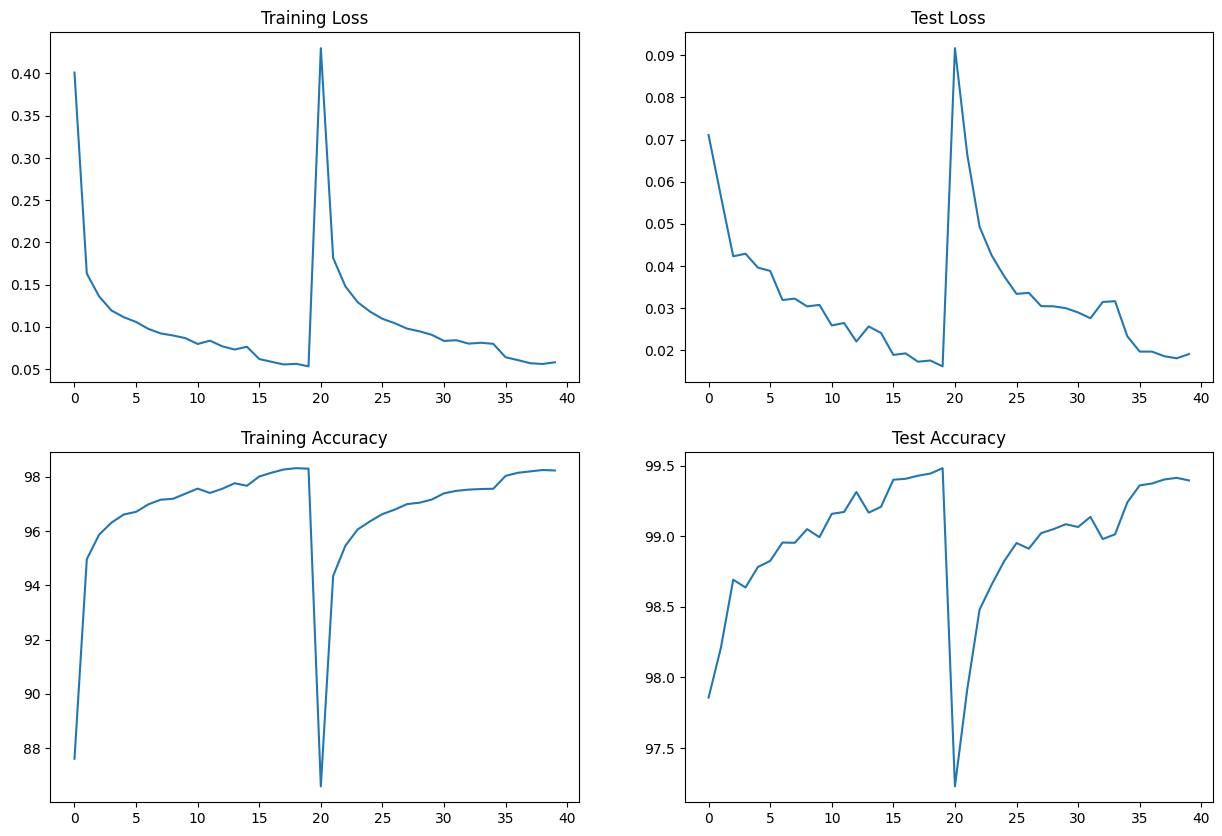

In [14]:
plot_loss_n_acc()